## Problem 12 - selecting the right bandwidth

In this problem we will try out band-width selection in two steps. 

## Preparation: Loading of packages and data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KernelDensity

%matplotlib inline

In [4]:
def read_bh_masses():
    """
    Read in black hole masses from CSV file
    """
    
    fname = 'joint-bh-mass-table.csv'
    t = Table().read(fname)
    return t

In [5]:
t_bh = read_bh_masses()

a) Select the best band-width by linear search.

In [6]:
def show_one_bandwidth(t, bw, what='MBH', xmin=0, xmax=70):
    """
    Show the KDE estimate of the masses with one band-width
    """
    
    X = t[what][:, np.newaxis]
    kde = KernelDensity(bandwidth=bw, kernel='gaussian').fit(X)
    
    xgrid = np.linspace(xmin, xmax, 200)
    ln_p_bh = kde.score_samples(xgrid[:, np.newaxis])
    p_bh = np.exp(ln_p_bh)
    
    h = plt.hist(t[what], normed='area')
    plt.plot(xgrid, p_bh)
    plt.title("Bandwidth={0}".format(bw))
    plt.xlabel(r'$M_{BH}$')
    plt.ylabel(r'$P(M_{BH})$')
    
    return kde

def score_one_bandwidth(t, bw, kernel='gaussian'):
    """
    Fit a KDE and get its score on the fitted sample.
    
    It returns the log likelihood of the data.
    """
    X = t['MBH'][:, np.newaxis]
    kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(X)
    score = kde.score(X)
    
    return score

def score_many_bandwidths(t, kernel='gaussian', bws=None):
    """
    Fit many bandwidths
    """
    if bws is None:
        bws = np.linspace(1, 7.0, 100)
        
    scores = np.zeros_like(bws)
    for i, bw in enumerate(bws):
        scores[i] = score_one_bandwidth(t, bw, kernel=kernel)
    
    return bws, scores
    

In [7]:
bws, scores = score_many_bandwidths(t_bh)

Text(0, 0.5, 'Ln P(train)')

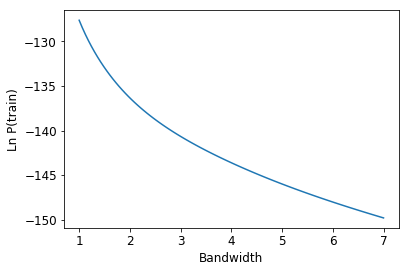

In [8]:
plt.plot(bws, scores)
plt.xlabel('Bandwidth')
plt.ylabel('Ln P(train)')

b) Use cross-validation to find the optimal bandwidth.

We do this manually using `KFold` and then I'll show `GridSearchCV` at the end.

In [9]:
def cv_bh_masses(x, bws, kernel='gaussian', plot=False, n_splits=10):
    """
    This calculates leave-one-out cross validation. 
    
    Parameters: 
       x: The values to do cross-validation over. 
       bws: The band-width range to explore
       
    Keyword parameters:
       kernel: The kernel to use. Must be one supported by 
               sklearn.neighbors.KernelDensity. Default: 'gaussian'
     n_splits: The number of splits to use for the cross-validation. 
               Recommended values is 5-10. Default: 10
         plot: Set this to create a grid of test & training samples. This
               is mostly useful for debugging and does not lead to pretty results

    Returns:
         cv_1: The cross-validation scores (log likelihoods) of each bandwidth tried.
    
    """

    # Get the number of bandwidths to check and the number of objects
    N_bw = len(bws)
    N = len(x)
    cv_1 = np.zeros(N_bw)
    
    if x.ndim == 1:
        X = x[:, np.newaxis]
    else:
        X = x
    
    # If plotting is requested, set up the plot region
    if plot:
        fig, axes = plt.subplots(N_bw, np.ceil(N/n_splits), figsize=(15, 8))
        xplot = np.linspace(0, 70, 1000)

    # Loop over each band-width and calculate the probability of the 
    # test set for this band-width
    for i, bw in enumerate(bws):
    
        # I will do N-fold CV here. This divides X into N_folds
        kf = KFold(n_splits=n_splits)

        # Initiate - lnP will contain the log likelihood of the test sets
        # and i_k is a counter for the folds that is used for plotting and
        # nothing else..
        lnP = 0.0
        i_k = 0
                                 
        # Loop over each fold
        for train, test in kf.split(X):
            x_train = X[train, :]
            x_test = X[test, :]
            
            # Create the kernel density model for this bandwidth and fit
            # to the training set.
            kde = KernelDensity(kernel=kernel, bandwidth=bw).fit(x_train)
                                 
            # score evaluates the log likelihood of a dataset given the fitted KDE.
            log_prob = kde.score(x_test)
            
            if plot:
                # Show the tries
                ax = axes[i][i_k]

                # Note that the test sample is hard to see here.
                hist(x_train, bins=10, ax=ax, color='red')
                hist(x_test, bins=10, ax=ax, color='blue')
                ax.plot(xplot, np.exp(kde.score_samples(xplot[:, np.newaxis])))
                i_k += 1
            

            lnP += log_prob
            
        # Insert the log likelihood          
        cv_1[i] = lnP
        
    return cv_1


In [10]:
cv = cv_bh_masses(t_bh['MBH'], bws)

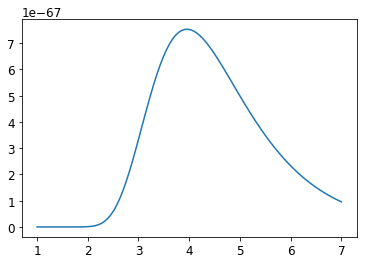

In [11]:
plt.plot(bws, np.exp(cv))

In [12]:
print("The best bandwidth = {0}".format(bws[np.argmax(cv)]))

The best bandwidth = 3.9696969696969697


/Users/jarle/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


KernelDensity(algorithm='auto', atol=0, bandwidth=3.97, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

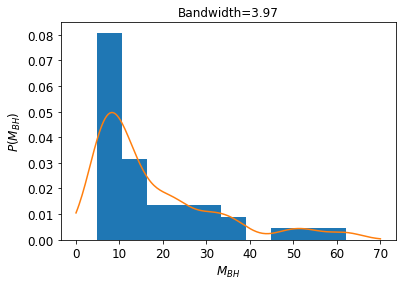

In [13]:
show_one_bandwidth(t_bh, 3.97)

# Problem 13 - neutron stars

The file `pulsar_masses.vot` contains masses of pulsars from Özel & Freire 2016, Annual Reviews of Astronomy and Astrophysics, taken from the [associated web page](http://xtreme.as.arizona.edu/NeutronStars/). 

On October 15, 2017, the LIGO/Virgo consortium and host of ground- and space-based observatories announced the discovery of an optical counter-part to the gravitational wave source GW170817. The two neutron stars that are thought have merged to produce the gravitational wave signal, have estimated masses of $M_1 = 1.81 \,\mathrm{M}_\odot$ and $M_2=1.11\,\mathrm{M}_\odot$. 
  
  a) Use the pulsar mass catalogue to estimate the likelihood of finding a neutron star with $M>1.8\,\mathrm{M}_\odot$.

  b) Actually the mass estimates are ranges, and the masses were $M_1\in [1.36, 2.26]$ and $M_2 \in [0.86, 1.36]$. What are the likelihoods of those mass ranges and the likelihood of the binary?
  
  c) There are many assumptions made that I did not spell out - make a list of some that you worry about.

In [14]:
def read_NS_masses():
    """
    Read in neutron star masses from VOT file
    """
    
    fname = 'pulsar_masses.vot'
    t = Table().read(fname)
    return t

## a) 

To solve this, we need the likelihood distribution of neutron star masses, $P\left(M_{NS})\right)$. The information we have available is the distribution of masses of neutron stars in the indicated paper. To estimate $P(M_{NS})$ we then use kernel density estimation. The first step then is to estimate the bandwidth of the kernel density estimate.


In [15]:
# First, read the masses in
t_NS = read_NS_masses()
t_NS.colnames

['Mass', 'dMlow', 'dMhigh', 'Category', 'Order', 'Name']

In [16]:
# Find the range of masses to consider
np.min(t_NS['Mass']), np.max(t_NS['Mass'])

(0.951, 2.634)

In [17]:
# We can use the same cross-validation technique as above here, just changing the band-widths to consider
bws_ns = np.linspace(0.05, 0.5, 100)
cv = cv_bh_masses(t_NS['Mass'], bws_ns)

Text(0, 0.5, 'P(data)')

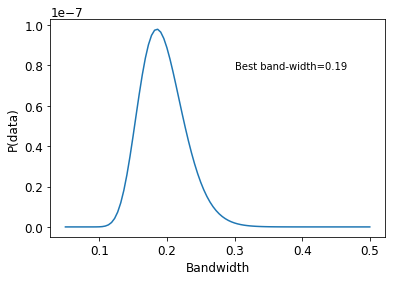

In [18]:
P_cv = np.exp(cv)
plt.plot(bws_ns, P_cv)
plt.text(0.3, 0.8*np.max(P_cv), "Best band-width={0:.2f}".format(bws_ns[np.argmax(P_cv)]))
plt.xlabel('Bandwidth')
plt.ylabel('P(data)')

/Users/jarle/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


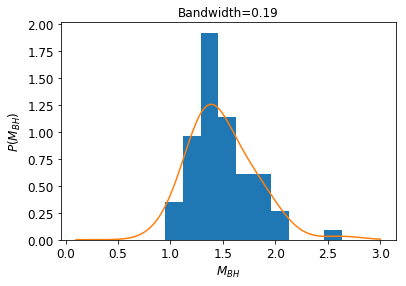

In [19]:
kde = show_one_bandwidth(t_NS, 0.19, what='Mass', xmin=0.1, xmax=3.0)

Now, to solve a (and b) we want to integrate the resulting KDE estimate. To do that we can first evaluate it on a fine grid and integrate.

In [20]:
def p_of_distribution(kde, xmin=1.0, xmax=None):
    """
    Evaluate a KDE over a region and integrate up.
    """
    if xmax is None:
        xmax = 5.0 # used as a practical maximum
    
    # This does the whole grid
    xgrid = np.linspace(0.0, 5.0, 1000)
    ln_p_ns = kde.score_samples(xgrid[:, np.newaxis])
    p_ns = np.exp(ln_p_ns)
    
    # Integrate this to get the normalisation
    norm = np.trapz(p_ns, xgrid)
    
    # Then the subrange
    xint = np.linspace(xmin, xmax, 1000)
    p_int = np.exp(kde.score_samples(xint[:, np.newaxis]))
    I1 = np.trapz(p_int, xint)
    
    return I1, norm
    
    
    
    

In [21]:
I1, norm = p_of_distribution(kde, xmin=1.8)

In [22]:
print("The likelihood of finding a neutron star with M > 1.8={0:.3f}".format(I1/norm))

The likelihood of finding a neutron star with M > 1.8=0.176


In [23]:
I_range1, norm = p_of_distribution(kde, xmin=1.36, xmax=2.26)
I_range2, norm = p_of_distribution(kde, xmin=0.86, xmax=1.36)

In [24]:
print("P([1,36, 2.26]) = {0:.3f},   P([0.86, 1.36] = {1:.3f})".format(I_range1/norm,
                                                                      I_range2/norm))

P([1,36, 2.26]) = 0.598,   P([0.86, 1.36] = 0.360)


In [25]:
print("The likelihood of the binary={0:.3f}".format(I_range1*I_range2/norm**2))

The likelihood of the binary=0.215


### c) Some assumptions made

* I have assumed that the neutron star masses in the file are representative of the underlying population of neutron stars. This might be fair assumption but that is not obvious.
* I have assumed that the binary neutron stars have the same mass distribution as single neutron stars. 
* I have assumed uncertainties on the masses are negligible (not a terribly good assumption).